In [26]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from pysindy import SINDy
from pysindy.feature_library import PolynomialLibrary
from pysindy.optimizers import STLSQ

In [27]:
# --- Step 1: Load and preprocess image sequence ---
def load_image_sequence(folder_path, filenames, size=(64, 64), grayscale=True):
    data = []
    for fname in sorted(filenames):
        path = os.path.join(folder_path, fname)
        img = Image.open(path)
        if grayscale:
            img = img.convert('L')  # Convert to grayscale
        img = img.resize(size)
        img_arr = np.array(img) / 255.0  # Normalize to [0, 1]
        data.append(img_arr)
    return np.stack(data)  # shape: (time, height, width)

# Red dye setup
red_folder = "red-dye"
red_filenames = [f"dye{i}.png" for i in range(1, 19)]  # dye1.png to dye18.png
u = load_image_sequence(red_folder, red_filenames)

dt = 0.4  # Time step in seconds

In [28]:
# --- Step 2: Compute derivatives ---
def compute_derivatives(u, dt=10):
    u_smoothed = gaussian_filter(u, sigma=(0, 1, 1))  # Smooth spatially

    du_dt = np.gradient(u_smoothed, dt, axis=0)
    ux = np.gradient(u_smoothed, axis=2)
    uy = np.gradient(u_smoothed, axis=1)
    uxx = np.gradient(ux, axis=2)
    uyy = np.gradient(uy, axis=1)

    return du_dt, uxx + uyy

du_dt, laplacian = compute_derivatives(u, dt=dt)

In [29]:
# --- Step 3: Flatten data for SINDy ---
X = np.stack([u, laplacian], axis=-1).reshape(-1, 2)  # Features: u, laplacian
dX = du_dt.reshape(-1, 1)                            # Target: du/dt

# --- Step 4: Fit SINDy Model ---
feature_library = PolynomialLibrary(degree=1, include_interaction=False)
optimizer = STLSQ(threshold=0.01)

model = SINDy(
    optimizer=optimizer,
    feature_library=feature_library,
    feature_names=['u', 'laplacian']
)

model.fit(X, x_dot=dX)
model.print()


(u)' = -0.030 1 + 0.032 u + 0.033 laplacian


In [32]:
# --- Function: Forward prediction ---
def predict_forward(u0, model, n_steps, dt):
    """
    Predict forward in time using the learned model and finite difference features.

    Parameters:
        u0: 2D array, initial condition
        model: trained regression model from SINDy
        n_steps: int, how many time steps to predict
        dt: float, time step size

    Returns:
        u_pred: list of 2D arrays representing predictions at each time step
    """
    u_pred = [u0]
    current = u0

    for _ in range(n_steps):
        # Compute second derivatives (Laplacian)
        ux = np.gradient(current, axis=1)
        uy = np.gradient(current, axis=0)
        uxx = np.gradient(ux, axis=1)
        uyy = np.gradient(uy, axis=0)
        lap = uxx + uyy

        # Ensure arrays are standard NumPy arrays before stacking
        current_np = np.array(current)
        lap_np = np.array(lap)

        # Stack features and reshape
        features = np.stack([current_np, lap_np], axis=-1).reshape(-1, 2)

        # Predict derivative using model
        du_dt_pred = model.predict(features).reshape(current.shape)

        # Euler integration step
        next_u = current + dt * du_dt_pred
        u_pred.append(next_u)
        current = next_u

    return u_pred

In [42]:
# --- Step 6: Predict and compare to true frames ---
start_idx = 7
n_predict = 5
u0 = u[start_idx]  # Initial condition

u_pred = predict_forward(u0, model, n_steps=n_predict, dt=dt)
u_true = u[start_idx:start_idx + n_predict + 1]  # Ground truth


Step 1:
Mean absolute error: 0.027012484681372545


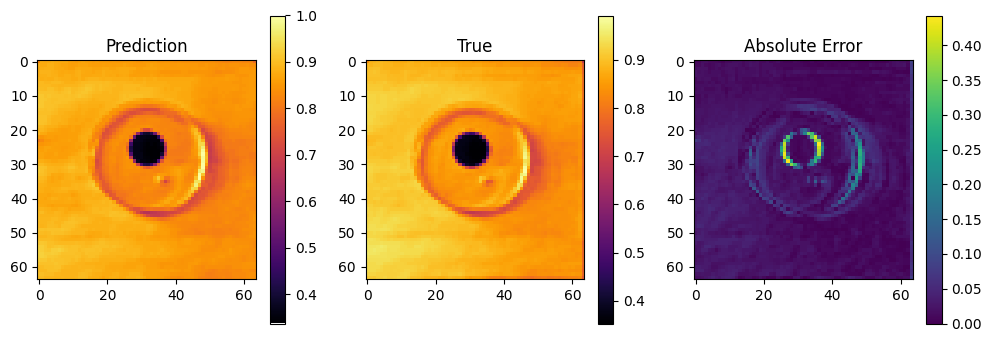

Step 2:
Mean absolute error: 0.03892822533979243


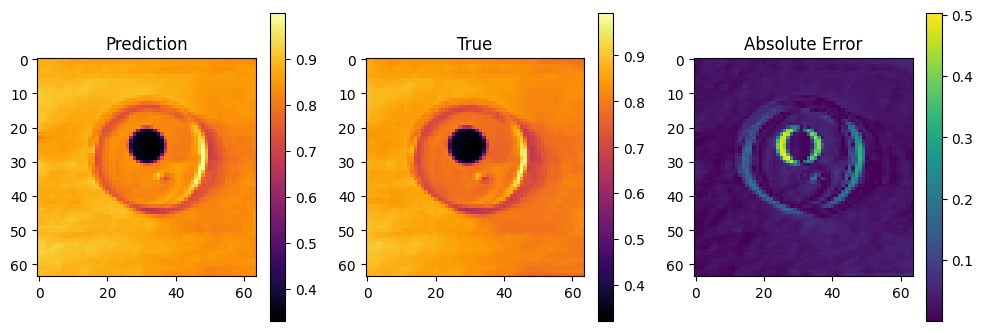

Step 3:
Mean absolute error: 0.022745377360033396


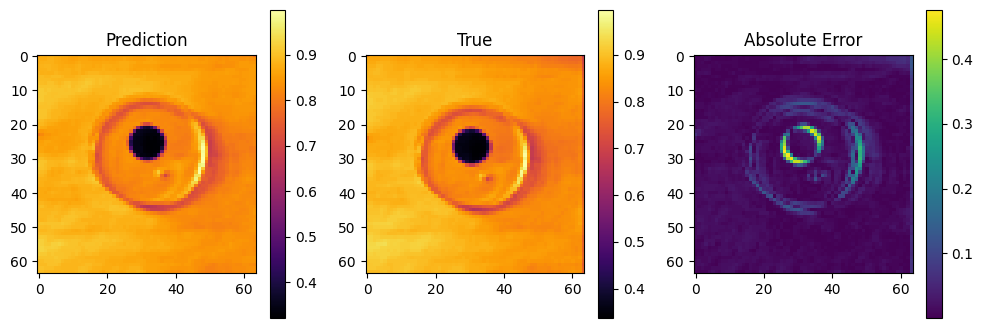

In [47]:
# # --- Visualization ---

start_idx = 1
n_predict = 3
u0 = u[start_idx]

# Predict future steps
u_pred = predict_forward(u0, model, n_steps=n_predict, dt=dt)

# Compare to true values
for i in range(n_predict):
    pred_frame = u_pred[i]
    true_frame = u[start_idx + i + 1]

    print(f"Step {i+1}:")
    #print("Predicted shape:", pred_frame.shape)
    #print("True shape:", true_frame.shape)

    abs_error = np.abs(pred_frame - true_frame)
    print("Mean absolute error:", abs_error.mean())

    # visualize
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Prediction")
    plt.imshow(pred_frame, cmap='inferno')
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.title("True")
    plt.imshow(true_frame, cmap='inferno')
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.title("Absolute Error")
    plt.imshow(abs_error, cmap='viridis')
    plt.colorbar()

    plt.show()